<h1><center>STAT-542 HW6</center></h1>
Sharvi Tomar (stomar2)

## About HW6

Understand how the spline basis is constructed. We will use the Ozone data from the mlbench package.

Kernel regression involves two decisions: choosing the kernel and tuning the bandwidth. Usually, tuning the bandwidth is more influential than choosing the kernel function. Tuning the bandwidth is similar to tuning k in a KNN model. However, this is more difficult in multi-dimensional models. We practice one and two-dimensional kernels that involves these elements.

## Question 1 [40 Points] Write Your Own Spline Basis (Univariate Spline Fit)


We will fit and compare different spline models to the Ozone dataset form the mlbench package. We have pre-processed this dataset. Please use our provided train/test csv files. This dataset has three variables: time, ozone and wind. For the spline question, we will only use time as the covariate and ozone as the outcome.

In [127]:
import pandas as pd
train = pd.read_csv("ozoneTrain.csv")
test = pd.read_csv("ozoneTest.csv")

In [128]:
train = train.sort_values('time')
train.reset_index(inplace=True)
test = test.sort_values('time')
test.reset_index(inplace=True)

Text(0, 0.5, 'ozone')

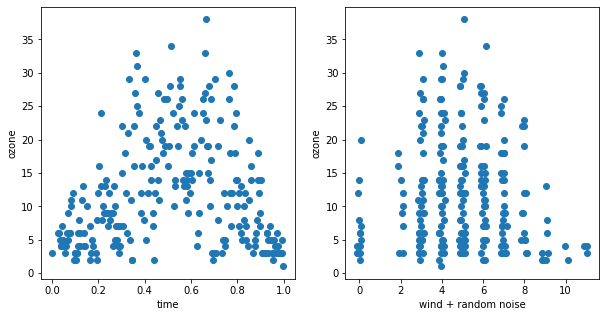

In [131]:
import matplotlib.pyplot as plt
import numpy as np

plt.subplots(2,2,figsize=(10,5))

plt.subplot(1, 2, 1) 
plt.scatter(train["time"], train["ozone"])
plt.xlabel('time') 
plt.ylabel('ozone') 

plt.subplot(1, 2, 2)
plt.scatter(train["wind"] + np.random.uniform(-0.15, 0.15,len(train)), train["ozone"]) 
plt.xlabel('wind + random noise') 
plt.ylabel('ozone')

Let’s consider several different spline constructions to model the ozone level using time. Please read the requirements carefully since some of them require you to write your own code. - To test your model, use the train/test split provided above. 

* Use the mean squared error as the metric for evaluation and report the MSE for each method in a single summary table. 

* For the spline basis that you write with your own code, make sure to include the intercept term. 

* For question a) and b) and d), provide the following summary information at the end of your answer: 

* A table of MSE on testing data. Please label each method clearly. 

* Three figures (you could consider making them side-by-side for a better comparison) at the end. Each figure consists of scatter plots of both training and testing data points and the fitted curve on the range x = seq(0, 1, by = 0.01).

a) [10 pts] Write your own code (you cannot use bs() or similar functions) to implement a continuous piece-wise linear fitting. Pick 4 knots at (0.2,0.4,0.6,0.8).

In [355]:
# Helper function to return Identity function output of (x-b)
def Id(x):
    res = np.zeros(len(x))
    for i in range(len(x)):
        if x[i]> 0: res[i] = x[i]
        else: res[i] = 0    
    return res

In [356]:
knots = [0.2, 0.4,0.6,0.8]

def linear_basis(data, knots):
    intercept = [1]* len(data)
    x_11 = data
    x_22 = Id(data - knots[0]) 
    x_33 = Id(data - knots[1]) 
    x_44 = Id(data - knots[2]) 
    x_55 = Id(data - knots[3])
    
    return np.column_stack((intercept, x_11, x_22, x_33, x_44, x_55))

In [357]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

knots = [0.2, 0.4,0.6,0.8]

# Fitting and predicting on train data
model_a = LinearRegression(fit_intercept = False)
model_a.fit(linear_basis(train["time"], knots),train["ozone"])
train_pred_a = model_a.predict(linear_basis(train["time"], knots))

# Predicting on test data
pred_a = model_a.predict(linear_basis(test["time"], knots))

# MSE on test data
mse_a = mean_squared_error(test["ozone"], pred_a)

print("The MSE on test data is:", mse_a)

The MSE on test data is: 31.085649874035155


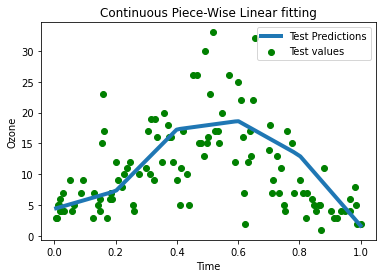

In [375]:
plt.title("Continuous Piece-Wise Linear fitting")
plt.xlabel("Time")
plt.ylabel("Ozone")
plt.plot(test.time, pred_a, linewidth=4)
plt.scatter(test.time, test.ozone, c='green')
plt.legend(["Test Predictions","Test values"])

b) [10 pts] Write your own code to implement a quadratic spline fitting. Your spline should be continuous up to the first derivative. Pick 4 knots as (0.2,0.4,0.6,0.8).

In [358]:
knots = [0.2, 0.4,0.6,0.8]

def quadratic_basis(data, knots):
    intercept = [1]* len(data)
    x_11 = data
    x_12 = data ** 2
    x_22 = Id(data - knots[0]) ** 2
    x_33 = Id(data - knots[1]) ** 2
    x_44 = Id(data - knots[2]) ** 2
    x_55 = Id(data - knots[3]) ** 2
    
    return np.column_stack((intercept, x_11, x_12, x_22, x_33, x_44, x_55))

In [359]:
knots = [0.2, 0.4,0.6,0.8]

# Fitting and predicting on train data
model_b = LinearRegression(fit_intercept = False)
X_b = quadratic_basis(train["time"], knots)
model_b.fit(X_b, train["ozone"])
train_pred_b = model_b.predict(quadratic_basis(train["time"], knots))

# Predicting on test data
pred_b = model_b.predict(quadratic_basis(test["time"], knots))

# MSE on test data
mse_b = mean_squared_error(test["ozone"], pred_b)
print("The MSE on test data is:", mse_b)

The MSE on test data is: 30.097512396513853


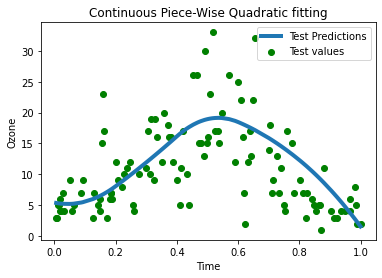

In [376]:
plt.title("Continuous Piece-Wise Quadratic fitting")
plt.xlabel("Time")
plt.ylabel("Ozone")
plt.plot(test.time, pred_b, linewidth=4)
plt.scatter(test.time, test.ozone, c='green')
plt.legend(["Test Predictions","Test values"])

c) [10 pts] Produce a set of B-spline basis with the same knots and degrees as (ii) using the bs() function. Note that they do not have to be exactly the same as yours. Compare the design matrix from b) and c) as follows:

* Check the the difference between their projection matrices (the hat-matrices of the corresponding linear regression) on the training data to verify that the column spaces are the same. The difference is measured by maxi,j|H(1)i,j−H(2)i,j|, where H(1) and H(2) are corresponding to the two hat-matrices.

* Compare the conditional number σmaxσmin of each deign matrix, where σmax and σmin denote the largest and smallest singular values, respectively.

* [bonus 2 pts] Why B-spline has a smaller condition number even though two design matrices have the same column space. Some basic information of the conditional number (for linear regression) can be found here.

In [360]:
from patsy import dmatrix
from numpy.linalg import inv, cond

X_c = dmatrix("bs(train.time, knots=(0.2, 0.4,0.6,0.8), degree=2)", return_type='dataframe')

# Projection matrix from design matrix
H_c = np.dot(X_c, inv(X_c.T @ X_c) @ X_c.T)
H_b = np.dot(X_b, inv(X_b.T @ X_b) @ X_b.T)

# Difference between projection matrices
max_abs_diff = -1
for i in range(H_c.shape[0]):
    for j in range(H_c.shape[1]):
        if abs(H_c[i][j]-H_b[i][j])>max_abs_diff: 
            max_abs_diff = abs(H_c[i][j]-H_b[i][j])   

print("The maximum absolute difference between the design matrices of b) and c) parts is:", max_abs_diff)            

The maximum absolute difference between the design matrices of b) and c) parts is: 6.333544799730362e-13


In [361]:
# Conditional number σmax/σmin of each design matrix
c_b = cond(X_b, p=None)
c_c = cond(X_c, p=None)

print("The conditional number for design matrix of part b) is:", c_b)
print("The conditional number for design matrix of part c) is:", c_c)

The conditional number for design matrix of part b) is: 920.7991913310985
The conditional number for design matrix of part c) is: 22.633005236297617


B-spline or basis spline is a spline function that has minimal support with respect to a given degree, and hence provides stable basis estimates. The condition number is smaller implies that its inverse can be computed with good accuracy. It will restrict the column space in a much better way than the basis from the custom fitting function and hence, would result in reliable estimates.

d) [10 pts] Use existing functions to implement a smoothing spline. Use the built-in generalized cross-validation method to select the best tuning parameter.

In [362]:
from scipy.interpolate import UnivariateSpline
from sklearn.model_selection import KFold
import numpy as np

kf = KFold(n_splits=3, random_state=None, shuffle=False)
param_vals = [1000*i for i in range(10)] 

mse_vals = np.zeros(len(param_vals))

for i in range(len(param_vals)):
    error = []
    for train_index, test_index in kf.split(train.time):
        X_train, X_test = train.time[train_index], train.time[test_index]
        y_train, y_test = train.ozone[train_index], train.ozone[test_index]
        
        spline = UnivariateSpline(X_train, y_train)
        spline.set_smoothing_factor(param_vals[i])
        pred = spline(X_test)
        error.append(mean_squared_error(y_test, pred)) 
        
    mse_vals[i] = np.mean(error)     

    
results = pd.DataFrame(list(zip(param_vals, mse_vals)))
results.columns = ['Smoothing_Factor', 'MSE'] 
results

,Smoothing_Factor,MSE
0,0,3.044619e+12
1,1000,1.441581e+11
2,2000,5.341275e+10
3,3000,6.561637e+09
4,4000,1.685806e+08
5,5000,2.158082e+08
6,6000,4.633696e+07
7,7000,3.551630e+06
8,8000,1.237640e+05
9,9000,5.935684e+01


In [370]:
best_spline = UnivariateSpline(train["time"], train["ozone"])
best_spline.set_smoothing_factor(param_vals[9])
train_pred_d = best_spline(train["time"])
pred_d = best_spline(test["time"])

mse_d = mse_vals[9]
print("The MSE on test data is:", mse_d)

The MSE on test data is: 59.35684399656849


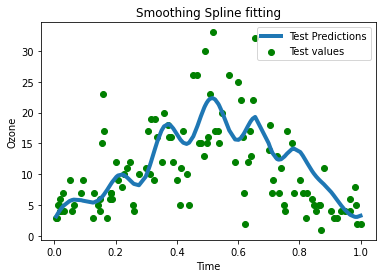

In [377]:
plt.title("Smoothing Spline fitting")
plt.xlabel("Time")
plt.ylabel("Ozone")
plt.plot(test.time, pred_d, linewidth=4)
plt.scatter(test.time, test.ozone, c='green')
plt.legend(["Test Predictions","Test values"])

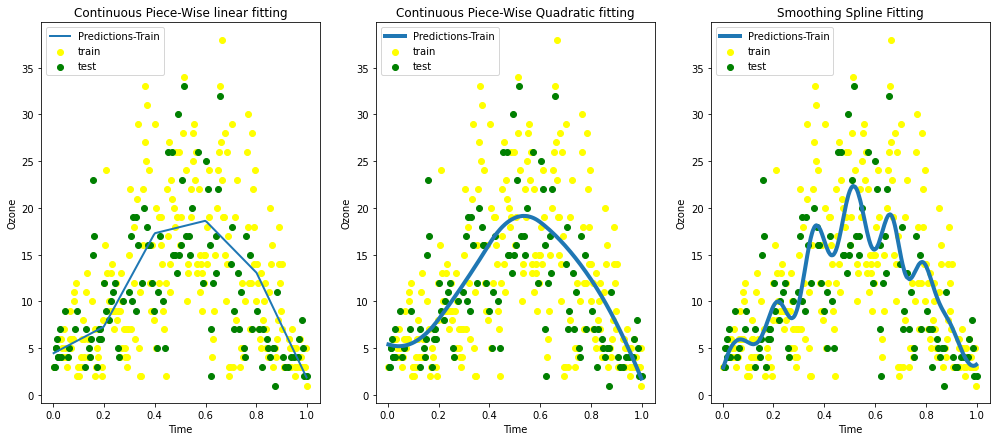

In [378]:
import matplotlib.pyplot as plt

plt.figure(figsize=(17,7))
x = np.arange(0, 1, 0.1)

plt.subplot(1, 3, 1)
plt.title("Continuous Piece-Wise linear fitting")
plt.xlabel("Time")
plt.ylabel("Ozone")
plt.plot(train.time, train_pred_a, linewidth=2)
plt.scatter(train.time, train.ozone,c='yellow')
plt.scatter(test.time, test.ozone, c='green')
plt.legend(["Predictions-Train","train","test"])

plt.subplot(1, 3, 2)
plt.title("Continuous Piece-Wise Quadratic fitting")
plt.xlabel("Time")
plt.ylabel("Ozone")
plt.plot(train.time, train_pred_b, linewidth=4)
plt.scatter(train.time, train.ozone,c='yellow')
plt.scatter(test.time, test.ozone, c='green')
plt.legend(["Predictions-Train","train","test"])

plt.subplot(1, 3, 3)
plt.title("Smoothing Spline Fitting")
plt.xlabel("Time")
plt.ylabel("Ozone")
plt.plot(train.time, train_pred_d, linewidth=4)
plt.scatter(train.time, train.ozone,c='yellow')
plt.scatter(test.time, test.ozone, c='green')
plt.legend(["Predictions-Train","train","test"])

plt.show()


In [379]:
from tabulate import tabulate
data = [["Linear Fitting Spline", mse_a, ], ["Quadratic Fitting Spline", mse_b], ["Smoothing Spline", mse_d]] 
print(tabulate(data, headers=["Method", "Test MSE"]))

Method                      Test MSE
------------------------  ----------
Linear Fitting Spline        31.0856
Quadratic Fitting Spline     30.0975
Smoothing Spline             59.3568


## Question 2 [60 Points] Kernel Regression

We will use the same ozone data. For Question a), we only use time as the covariate, while in Question b, we use both time and wind.

### a) [30 pts] One-dimensional kernel regression

You are required to implement (write your own code) two kernel regression models, using the following two kernels function, respectively:

* Gaussian kernel, defined as K(u)=12π√e−u22
* Epanechnikov kernel, defined as K(u)=34(1−u2) for |u|≤1.

For both kernel functions, incorporate a bandwidth λ. You should start with the Silverman’s rule-of-thumb for the choice of λ, and then tune λ (for example, increase or decrease by 10%, 20%, 30% etc.). Then, perform the following:

* I. [20 pts] Using just the Silverman’s rule-of-thumb, fit and plot the regression line with both kernel functions, in a single figure. Add the training/testing points, just like Question 1. Report the testing MSE of both methods in a table.
[10 pts] For the Epanechnikov kernel, tune the λ value by minimizing the testing error. Use a grid of 10 different λ values at your choice. What is the best λ value that minimizes the testing error? Plot your optimal regression line and report the best λ and the testing error.


In [264]:
import math

def gaussian_kernel(z):
    return (1/math.sqrt(2*math.pi))* math.exp((-z**2)/2)

def epanechnikov_kernel(z):
    if abs(z)<=1:
        return (3/4)*(1-z**2)
    else:
        return 0
    
def silverman(p, n, sigma):
    if p == 1: return 1.06 * sigma * (n**-0.2)
    else: return ((4/p+2)**(1/(p+4)))*n**(-1/(p+4))* sigma

In [265]:
def predict(X, covariates, outcome, lambda_val, kernel):
    '''Calculate weights and return prediction'''
    
    if kernel == "gaussian":
        kernels = [gaussian_kernel((covariates[i]-X)/lambda_val)/lambda_val for i in range(len(covariates))]
    else:
        kernels = [epanechnikov_kernel((covariates[i]-X)/lambda_val)/lambda_val for i in range(len(covariates))]
        
    weights = [(kernel/np.sum(kernels)) for kernel in kernels]
    
    return np.dot(weights, outcome) 

In [266]:
gaussian_pred = [0] * len(train)
epanechnikov_pred = [0] * len(train)

sigma = np.std(train.time)
lambda_val = silverman(1, len(train.time), sigma)

for i in range(len(train)):
    gaussian_pred[i] = predict(train.time[i], train.time, train.ozone, lambda_val, kernel = "gaussian")
    epanechnikov_pred[i] = predict(train.time[i], train.time, train.ozone,lambda_val, kernel = "epanechnikov")


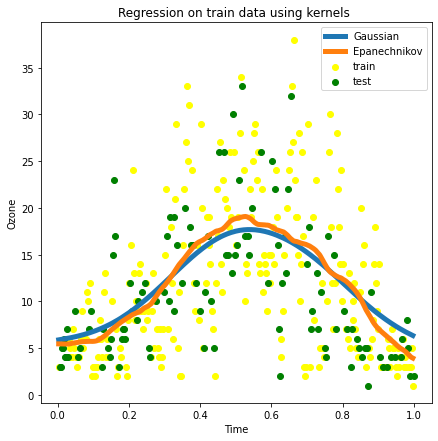

In [267]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,7))
plt.title("Regression on train data using kernels ")
plt.xlabel("Time")
plt.ylabel("Ozone")
plt.plot(train.time, gaussian_pred, linewidth=5)
plt.plot(train.time, epanechnikov_pred, linewidth=5)
plt.scatter(train.time, train.ozone,c='yellow')
plt.scatter(test.time, test.ozone, c='green')
plt.legend(["Gaussian", "Epanechnikov","train","test"])

In [268]:
from tabulate import tabulate

gaussian_pred_test = [0] * len(test)
epanechnikov_pred_test = [0] * len(test)

for i in range(len(test)):
    gaussian_pred_test[i] = predict(test.time[i], train.time, train.ozone, lambda_val, kernel = "gaussian")
    epanechnikov_pred_test[i] = predict(test.time[i], train.time, train.ozone,lambda_val, kernel = "epanechnikov")


gaussian_mse = mean_squared_error(gaussian_pred, train.ozone)
epanechnikov_mse = mean_squared_error(epanechnikov_pred, train.ozone)

gaussian_mse_test = mean_squared_error(gaussian_pred_test, test.ozone)
epanechnikov_mse_test = mean_squared_error(epanechnikov_pred_test, test.ozone)

data = [["Gaussian", gaussian_mse, gaussian_mse_test], ["Epanechnikov", epanechnikov_mse, epanechnikov_mse_test]] 

print (tabulate(data, headers=["Kernel", "Train MSE", "Test MSE"]))

Kernel          Train MSE    Test MSE
------------  -----------  ----------
Gaussian          43.3159     30.0694
Epanechnikov      42.0972     29.8725


In [269]:
# Tuning the λ for the Epanechnikov kernel

lambda_seq1 = [lambda_val - lambda_val*(0.2**i) for i in range(5)]
lambda_seq2 = [lambda_val + lambda_val*(0.2**i) for i in range(5)]
lambda_seq = lambda_seq1 + lambda_seq2
lambda_seq = lambda_seq[1:]
lambda_seq

[0.08105902046858808,
 0.0972708245623057,
 0.10051318538104922,
 0.10116165754479793,
 0.2026475511714702,
 0.12158853070288213,
 0.10537672660916451,
 0.10213436579042098,
 0.10148589362667228]

In [270]:
epanechnikov_mse = []
epanechnikov_predictions_test = [0] * len(test)

for l in lambda_seq:
    for i in range(len(test)):
        epanechnikov_predictions_test[i] = predict(test.time[i], train.time, train.ozone, l, kernel = "epanechnikov")
    epanechnikov_mse.append(mean_squared_error(epanechnikov_predictions_test, test.ozone))
df = pd.DataFrame(list(zip(lambda_seq, epanechnikov_mse)))
df.columns = ['lambda_seq', 'MSE'] 
df

,lambda_seq,MSE
0,0.081059,29.177896
1,0.097271,29.863291
2,0.100513,29.870217
3,0.101162,29.871588
4,0.202648,29.787805
5,0.121589,29.974913
6,0.105377,29.890559
7,0.102134,29.877382
8,0.101486,29.873474


The optimal value of $\lambda$ is: $0.081059$ with MSE value of $29.177896$ on test data

<function matplotlib.pyplot.show(close=None, block=None)>

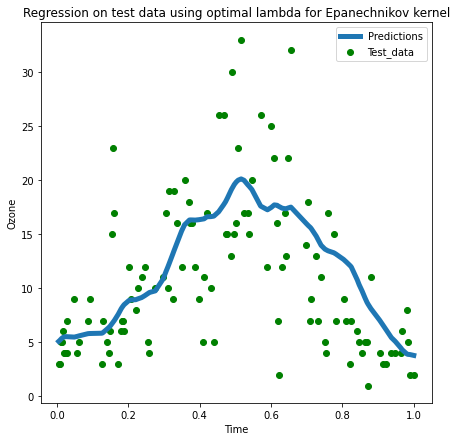

In [172]:
optimal_lambda = lambda_seq[0]
for i in range(len(test)):
        epanechnikov_predictions_test[i] = predict(test.time[i], train.time, train.ozone, optimal_lambda, kernel = "epanechnikov")
        
plt.figure(figsize=(7,7))
plt.title("Regression on test data using optimal lambda for Epanechnikov kernel")
plt.xlabel("Time")
plt.ylabel("Ozone")
plt.plot(test.time, epanechnikov_predictions_test, linewidth=5)
plt.scatter(test.time, test.ozone, c='green')
plt.legend(["Predictions", "Test_data"])
plt.show

### b) [25 Points] Two-dimensional Kernel

We consider using both time and wind in the regression. We use the following multivariate kernel function, which is essentially a Gaussian kernel with diagonal covariance matrix. You can also view this as the product of two kernel functions, corresponding to the two variables:

Kλ(x,z)∝exp{−12∑j=1p((xj−zj)/λj)2}
Based on the Silverman’s formula, the bandwidth for the jth variable is given by
λk=(4p+2)1p+4n−1p+4σˆj,
where σˆj is the estimated standard deviation for variable j. Use the Nadaraya-Watson kernel estimator to fit and predict the ozone level using time and wind. At the end, report the testing error.

In [333]:
def nw_kernel(z):
    return math.exp(-0.5*(z**2))

def predict_nw(X, cov, outcome, lambda_val):
    '''Calculate weights and return prediction'''
    k1 = [nw_kernel((cov[i][0]-X)/lambda_val[0]) for i in range(len(cov))]
    w1 = [(kernel/np.sum(k1)) for kernel in k1]
    k2 = [nw_kernel((cov[i][1]-X)/lambda_val[1]) for i in range(len(cov))]
    w2 = [(kernel/np.sum(k2)) for kernel in k2]
    
    return np.dot(w1, outcome) 

In [336]:
sigma_seq = [np.std(train.time), np.std(train.wind)]
lambda_silver = [silverman(2, len(train.time), sigma_seq[j]) for j in range(2)]

nw_pred_train = [0] * len(train)
nw_pred_test = [0] * len(test)

for i in range(len(train)):
    nw_pred_train[i] = predict_nw(train.time[i], np.asarray(train.iloc[:,[2,4]]), train.ozone, lambda_silver)

for i in range(len(test)):
    nw_pred_test[i] = predict_nw(test.time[i], np.asarray(train.iloc[:,[2,4]]), train.ozone, lambda_silver)

mse2 = mean_squared_error(nw_pred_test, test.ozone) 
print("The MSE on test data is:",mse2)

The MSE on test data is: 32.35228621077998


<function matplotlib.pyplot.show(close=None, block=None)>

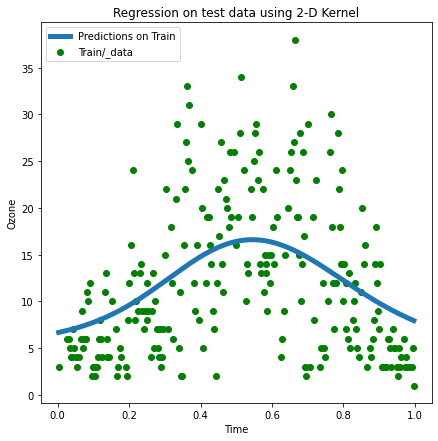

In [337]:
plt.figure(figsize=(7,7))
plt.title("Regression on test data using 2-D Kernel")
plt.xlabel("Time")
plt.ylabel("Ozone")
plt.plot(train.time, nw_pred_train, linewidth=5)
plt.scatter(train.time, train.ozone, c='green')
plt.legend(["Predictions on Train", "Train/_data"])
plt.show

### c) [5 Points] Variance of Multi-dimensional Kernel

In our lecture, we only introduced the one-dimensional case for density estimations. For a regression problem, the rate is essentially the same. However, when we have multivariate kernels, the rate of bias and variance will change. If we use the same λ from the one-dimensional case in a two-dimensional problem, would you expect the bias to increase/decrease/unchanged? Would you expect the variance to increase/decrease/unchanged? And why? Hint: for the same λ, bias is quantified by how far your neighboring points are, and variance is quantified by how many points you are capturing within that neighborhood.

### Answer:

With increase in the number of dimensions, for the same lambda value the points will be spread out in a bigger region. This effect would be cancelled by the kernel as it weighs the points higher for closer distance and smaller for larger distance. Hence, the overall impact on bias would be that it would remain unchanged. 

Variance will increase with increase in dimension as the number of points will be lesser in the same neighbourhood now with increased dimension unless the sample size is increased. 